QUESTION 2 - MVF 17 INDUSTRIES

C:\Users\Dell\AppData\Local\Temp\ipykernel_49988\1496054345.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_rf = pd.read_csv("FrenchFama.csv", index_col="Date", parse_dates=True)


Average monthly RF (1980-01 to 2024-12) = 0.3272

=== SAMPLE ESTIMATES ===
GMV (Sample):
  Mean Return  = 1.0673
  Volatility   = 3.4955
  Excess Return= 0.7401
  Sharpe Ratio = 0.2117

Tangency (Sample):
  Mean Return  = 1.1332
  Volatility   = 3.6333
  Excess Return= 0.8060
  Sharpe Ratio = 0.2218

=== JORION BS (MEANS ONLY) ===
  alpha = 0.5711,  lambda = 1.3315,  GMV return used = 1.0673
GMV (BS Means):
  Mean Return  = 1.0673
  Volatility   = 3.4955
  Excess Return= 0.7401
  Sharpe Ratio = 0.2117

Tangency (BS Means):
  Mean Return  = 1.0817
  Volatility   = 3.5270
  Excess Return= 0.7545
  Sharpe Ratio = 0.2139

=== JORION BS (MEANS + COVARIANCE) ===
  alpha = 0.5711,  lambda = 1.3315,  GMV return used = 1.0673
GMV (BS Means+Cov):
  Mean Return  = 1.0673
  Volatility   = 3.4969
  Excess Return= 0.7401
  Sharpe Ratio = 0.2116

Tangency (BS Means+Cov):
  Mean Return  = 1.0817
  Volatility   = 3.5284
  Excess Return= 0.7545
  Sharpe Ratio = 0.2138



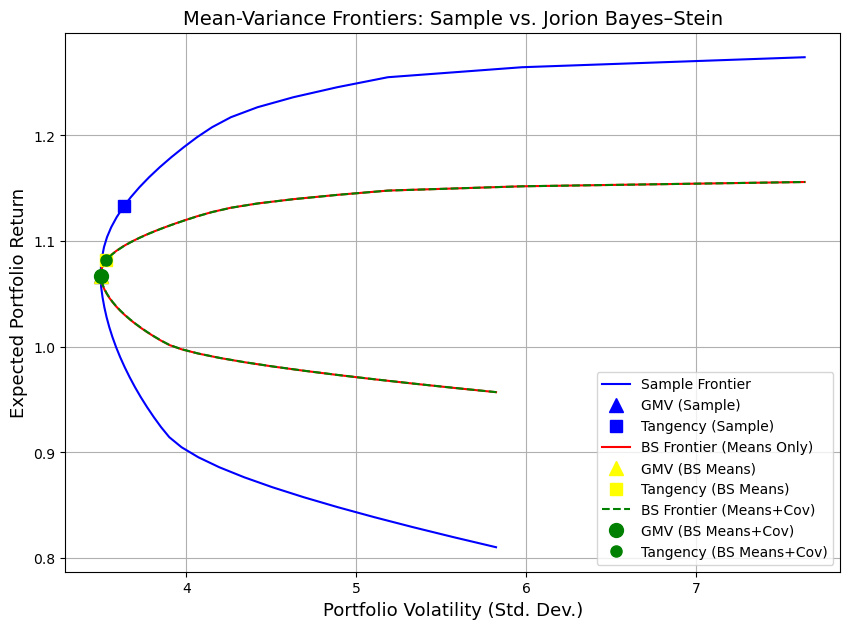

In [5]:
import numpy as np
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt


# 1. LOAD DATA

df_returns = pd.read_csv("PortData.csv", index_col="Date", parse_dates=True)
df_returns = df_returns.loc["1980-01":"2024-12"].dropna()

df_rf = pd.read_csv("FrenchFama.csv", index_col="Date", parse_dates=True)
df_rf = df_rf.loc["1980-01":"2024-12"].dropna()

# If RF is in percentage, convert to decimal if needed:
# df_rf["RF"] = df_rf["RF"] / 100.0

risk_free_rate = df_rf["RF"].mean()
print(f"Average monthly RF (1980-01 to 2024-12) = {risk_free_rate:.4f}")

N = df_returns.shape[1]  # number of assets
T = df_returns.shape[0]  # number of observations

# Sample mean & covariance
mean_returns_sample = df_returns.mean()   # (N,)
cov_matrix_sample   = df_returns.cov()    # (N,N)


# 2. HELPER FUNCTIONS

def portfolio_performance(weights, mean_returns, cov_matrix, rf=0.0):
    """Returns tuple: (Portfolio Return, Portfolio Vol, Portfolio Sharpe)."""
    ret = np.dot(weights, mean_returns)
    var = weights @ cov_matrix @ weights
    vol = np.sqrt(var)
    excess_ret = ret - rf
    sr = excess_ret / vol if vol > 1e-12 else 0.0
    return ret, vol, sr

def constraint_sum(weights):
    """Constraint that sum of weights = 1."""
    return np.sum(weights) - 1

def minimize_variance(weights, mean_returns, cov_matrix):
    """Objective function to minimize variance (for GMV)."""
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]**2

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    """Objective function to maximize Sharpe ratio => minimize negative Sharpe."""
    return -portfolio_performance(weights, mean_returns, cov_matrix, rf)[2]

def find_gmv(mean_returns, cov_matrix, bounds):
    """Find weights of the Global Minimum Variance portfolio."""
    constraints = ({'type': 'eq', 'fun': constraint_sum},)
    init_guess = np.ones(len(mean_returns)) / len(mean_returns)

    res = sco.minimize(
        fun=minimize_variance,
        x0=init_guess,
        args=(mean_returns, cov_matrix),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return res.x if res.success else None

def find_tangency(mean_returns, cov_matrix, rf, bounds):
    """Find weights of the Tangency (max Sharpe) portfolio."""
    constraints = ({'type': 'eq', 'fun': constraint_sum},)
    init_guess = np.ones(len(mean_returns)) / len(mean_returns)

    res = sco.minimize(
        fun=negative_sharpe_ratio,
        x0=init_guess,
        args=(mean_returns, cov_matrix, rf),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return res.x if res.success else None

def compute_frontier(mu_vector, cov_matrix, n_points=50):
    """
    Compute the efficient frontier by targeting returns from min to max 
    and minimizing variance subject to sum of weights = 1.
    """
    min_ret, max_ret = mu_vector.min(), mu_vector.max()
    target_returns = np.linspace(min_ret, max_ret, n_points)

    bounds = [(0,1)] * len(mu_vector)  # long-only in [0,1]
    init_guess = np.ones(len(mu_vector)) / len(mu_vector)

    frontier_risks = []
    frontier_returns = []

    def target_ret_constraint(w, mu, tr):
        return np.dot(w, mu) - tr

    for tr in target_returns:
        constraints = (
            {'type': 'eq', 'fun': constraint_sum},
            {'type': 'eq', 'fun': target_ret_constraint, 'args': (mu_vector, tr)}
        )
        res = sco.minimize(
            fun=minimize_variance,
            x0=init_guess,
            args=(mu_vector, cov_matrix),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        if res.success:
            frontier_risks.append(np.sqrt(res.fun))
            frontier_returns.append(tr)
        else:
            frontier_risks.append(np.nan)
            frontier_returns.append(tr)

    return np.array(frontier_risks), np.array(frontier_returns)


# 3. JORION’S BAYES–STEIN: (A) MEANS ONLY, (B) MEANS + COV

def jorion_bs_means_only(mu, Sigma, T, bounds):
    """
    Shrinks *only* the mean vector using Jorion's formula,
    but keeps the sample covariance matrix as-is.
    """
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    N = len(mu)
    ones = np.ones(N)

    # Find the global min variance portfolio return
    w_gmv = find_gmv(mu, Sigma, bounds)
    r_gmv = w_gmv @ mu if w_gmv is not None else mu.mean()

    Sigma_inv = np.linalg.inv(Sigma)
    diff = mu - r_gmv * ones
    denom = diff @ Sigma_inv @ diff

    lambda_raw = (N + 2) / T
    lambda_val = lambda_raw / denom if denom > 1e-12 else 0.0

    alpha = lambda_val / (1 + lambda_val)
    mu_BS = alpha * r_gmv * ones + (1 - alpha) * mu

    # Covariance is unchanged
    Sigma_BS = Sigma.copy()

    return mu_BS, Sigma_BS, alpha, lambda_val, r_gmv

def jorion_bs_means_and_cov(mu, Sigma, T, bounds):
    """
    Shrinks both mean vector and covariance using Jorion’s formula.
    """
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    N = len(mu)
    ones = np.ones(N)

    # Find the global min variance portfolio return
    w_gmv = find_gmv(mu, Sigma, bounds)
    r_gmv = w_gmv @ mu if w_gmv is not None else mu.mean()

    Sigma_inv = np.linalg.inv(Sigma)
    diff = mu - r_gmv * ones
    denom = diff @ Sigma_inv @ diff

    lambda_raw = (N + 2) / T
    lambda_val = lambda_raw / denom if denom > 1e-12 else 0.0

    alpha = lambda_val / (1 + lambda_val)
    mu_BS = alpha * r_gmv * ones + (1 - alpha) * mu

    factor_1 = (1 + 1/T + lambda_val) / (1 + lambda_val)
    factor_2 = lambda_val / (T * (1 + lambda_val))
    Sigma_BS = Sigma * factor_1 + factor_2 * np.outer(ones, ones) @ Sigma_inv

    return mu_BS, Sigma_BS, alpha, lambda_val, r_gmv


# 4. COMPUTE THREE FRONTIERS

ns_bounds = [(0,1)] * N  # long-only

# (i) Sample Frontier
risks_sample, rets_sample = compute_frontier(mean_returns_sample, cov_matrix_sample)

# (ii) Jorion BS (Means Only)
mu_bs_means, cov_bs_means, alpha_m, lambda_m, r_gmv_m = jorion_bs_means_only(
    mean_returns_sample, cov_matrix_sample, T, ns_bounds
)
risks_bs_means, rets_bs_means = compute_frontier(mu_bs_means, cov_bs_means)

# (iii) Jorion BS (Means + Cov)
mu_bs_both, cov_bs_both, alpha_b, lambda_b, r_gmv_b = jorion_bs_means_and_cov(
    mean_returns_sample, cov_matrix_sample, T, ns_bounds
)
risks_bs_both, rets_bs_both = compute_frontier(mu_bs_both, cov_bs_both)


# 5. FIND GMV & TANGENCY FOR EACH FRONTIER

def find_and_eval_portfolios(mu, Sigma, rf, label):
    w_gmv = find_gmv(mu, Sigma, ns_bounds)
    w_tan = find_tangency(mu, Sigma, rf, ns_bounds)

    if w_gmv is not None:
        rg, sg, sr_g = portfolio_performance(w_gmv, mu, Sigma, rf)
    else:
        rg, sg, sr_g = (np.nan, np.nan, np.nan)

    if w_tan is not None:
        rt, st, sr_t = portfolio_performance(w_tan, mu, Sigma, rf)
    else:
        rt, st, sr_t = (np.nan, np.nan, np.nan)

    return (w_gmv, rg, sg, sr_g), (w_tan, rt, st, sr_t)

def print_stats(label, w, r, s, sr, rf):
    """Helper to nicely print portfolio stats."""
    if w is None:
        print(f"{label} -> optimization failed.\n")
    else:
        print(f"{label}:")
        print(f"  Mean Return  = {r:.4f}")
        print(f"  Volatility   = {s:.4f}")
        print(f"  Excess Return= {(r - rf):.4f}")
        print(f"  Sharpe Ratio = {sr:.4f}\n")

# Sample
(gmv_samp, tan_samp) = find_and_eval_portfolios(mean_returns_sample, cov_matrix_sample, risk_free_rate, "Sample")

# BS Means Only
(gmv_bs_means_port, tan_bs_means_port) = find_and_eval_portfolios(mu_bs_means, cov_bs_means, risk_free_rate, "BS Means")

# BS Means + Cov
(gmv_bs_both_port, tan_bs_both_port) = find_and_eval_portfolios(mu_bs_both, cov_bs_both, risk_free_rate, "BS Means+Cov")


# 6. PRINT RESULTS

print("\n=== SAMPLE ESTIMATES ===")
print_stats("GMV (Sample)", *gmv_samp, risk_free_rate)
print_stats("Tangency (Sample)", *tan_samp, risk_free_rate)

print("=== JORION BS (MEANS ONLY) ===")
print(f"  alpha = {alpha_m:.4f},  lambda = {lambda_m:.4f},  GMV return used = {r_gmv_m:.4f}")
print_stats("GMV (BS Means)", *gmv_bs_means_port, risk_free_rate)
print_stats("Tangency (BS Means)", *tan_bs_means_port, risk_free_rate)

print("=== JORION BS (MEANS + COVARIANCE) ===")
print(f"  alpha = {alpha_b:.4f},  lambda = {lambda_b:.4f},  GMV return used = {r_gmv_b:.4f}")
print_stats("GMV (BS Means+Cov)", *gmv_bs_both_port, risk_free_rate)
print_stats("Tangency (BS Means+Cov)", *tan_bs_both_port, risk_free_rate)


# 7. PLOT ALL FRONTIERS

plt.figure(figsize=(10, 7))

# (i) Sample Frontier
plt.plot(risks_sample, rets_sample, 'b-', label='Sample Frontier')
if not np.isnan(gmv_samp[1]):
    plt.plot(gmv_samp[2], gmv_samp[1], 'b^', markersize=10, label='GMV (Sample)')
if not np.isnan(tan_samp[1]):
    plt.plot(tan_samp[2], tan_samp[1], 'bs', markersize=8, label='Tangency (Sample)')

# (ii) BS Frontier (Means Only)
plt.plot(risks_bs_means, rets_bs_means, 'r-', label='BS Frontier (Means Only)')
if not np.isnan(gmv_bs_means_port[1]):
    plt.plot(gmv_bs_means_port[2], gmv_bs_means_port[1], '^', color='yellow', markersize=10, 
             label='GMV (BS Means)')
if not np.isnan(tan_bs_means_port[1]):
    plt.plot(tan_bs_means_port[2], tan_bs_means_port[1], 's', color='yellow', markersize=8, 
             label='Tangency (BS Means)')

# (iii) BS Frontier (Means+Cov)
plt.plot(risks_bs_both, rets_bs_both, 'g--', label='BS Frontier (Means+Cov)')
if not np.isnan(gmv_bs_both_port[1]):
    plt.plot(gmv_bs_both_port[2], gmv_bs_both_port[1], 'o', color='green', markersize=10, 
             label='GMV (BS Means+Cov)')
if not np.isnan(tan_bs_both_port[1]):
    plt.plot(tan_bs_both_port[2], tan_bs_both_port[1], 'o', color='green', markersize=8, 
             label='Tangency (BS Means+Cov)')


# FINALIZE PLOT

plt.xlabel('Portfolio Volatility (Std. Dev.)', fontsize=13)
plt.ylabel('Expected Portfolio Return', fontsize=13)
plt.title('Mean-Variance Frontiers: Sample vs. Jorion Bayes–Stein', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


QUESTION 3 - MVF INDUSTRY VS STOCK

C:\Users\Dell\AppData\Local\Temp\ipykernel_28260\3824068323.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_ff = pd.read_csv(ff_file, index_col=0, parse_dates=True)


Performance Metrics (Sample Estimates):
 Dataset Portfolio  Expected Return  Volatility  Sharpe Ratio
Industry       GMV         0.010209    0.035142      0.217358
Industry  Tangency         0.010971    0.036755      0.228554
   Stock       GMV         0.011605    0.036024      0.250800
   Stock  Tangency         0.012970    0.038796      0.268068




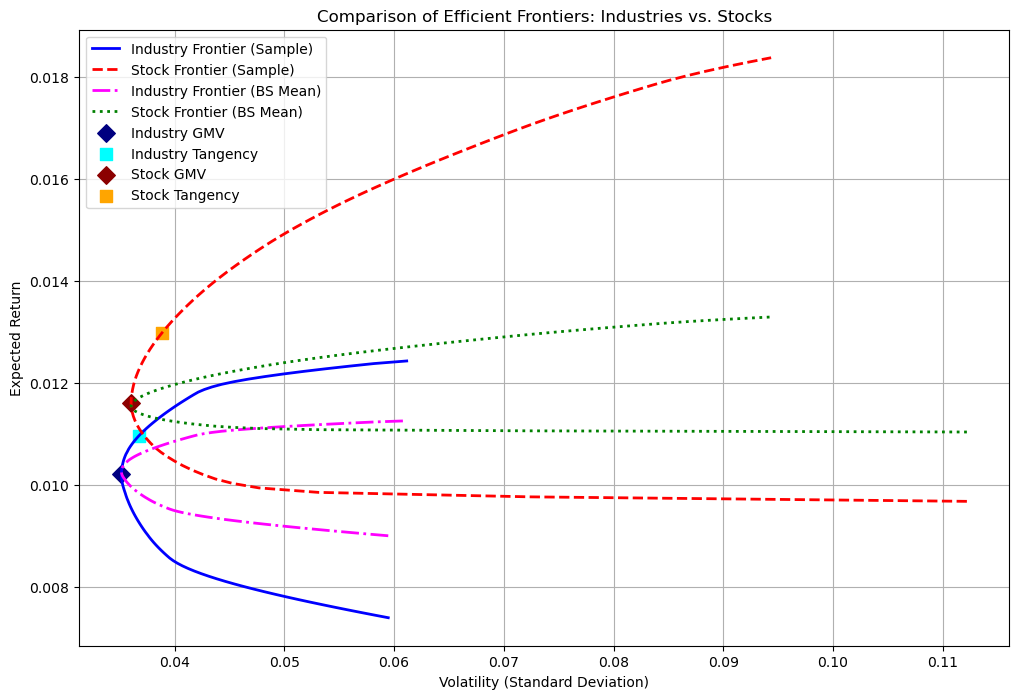

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --------------------------
# 1. Load and Prepare Data
# --------------------------
# Industry data
industry_file = "PortData.csv"
industry_data = pd.read_csv(industry_file, index_col=0, parse_dates=True)
industry_data = industry_data / 100  # convert percentages to decimals
industry_data = industry_data.loc['1985-01':'2024-12']

# Risk-free rate data (for industries)
ff_file = "FrenchFama.csv"
data_ff = pd.read_csv(ff_file, index_col=0, parse_dates=True)
data_ff = data_ff.loc['1985-01':'2024-12']
data_ff["RF"] = data_ff["RF"] / 100.0
rf_ind = data_ff["RF"].mean()  # average monthly risk-free rate for industries

# Sample estimates for industries
mu_ind = industry_data.mean()
cov_ind = industry_data.cov()

# Stock data (one stock per industry)
stocks_file = "17Stocks.csv"
data_stocks = pd.read_csv(stocks_file, index_col=0, parse_dates=True)
data_stocks = data_stocks.loc['1985-01':'2024-12']
simple_returns = data_stocks.pct_change().dropna()
mu_stock = simple_returns.mean()
cov_stock = simple_returns.cov()

# Given risk-free rate for stocks
rf_stock = 0.2570 / 100

# -----------------------------
# 2. Define Helper Functions
# -----------------------------
def portfolio_performance(weights, mu, cov):
    """Calculate portfolio return and volatility."""
    ret = np.dot(weights, mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return ret, vol

def min_variance(weights, mu, cov):
    """Objective: portfolio volatility."""
    return portfolio_performance(weights, mu, cov)[1]

def negative_sharpe_ratio(weights, mu, cov, rf):
    """Objective: negative Sharpe ratio (for tangency portfolio)."""
    ret, vol = portfolio_performance(weights, mu, cov)
    return - (ret - rf) / vol

def efficient_frontier(mu, cov, num_points=100):
    """Compute the efficient frontier given expected returns and covariance."""
    frontier = []
    for target_return in np.linspace(min(mu), max(mu), num_points):
        constraints = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w, mu=mu, tr=target_return: np.dot(w, mu) - tr}
        )
        bounds = [(0, 1)] * len(mu)
        w0 = np.ones(len(mu)) / len(mu)
        res = minimize(min_variance, w0, args=(mu, cov), method='SLSQP',
                       constraints=constraints, bounds=bounds)
        if res.success:
            ret, vol = portfolio_performance(res.x, mu, cov)
            frontier.append((vol, ret))
    return np.array(frontier)

def calculate_sharpe_ratio(ret, vol, rf):
    """Compute the Sharpe ratio."""
    return (ret - rf) / vol

# ---------------------------
# 3. Compute Sample Estimate Portfolios
# ---------------------------
# --- Industries (Sample Estimates) ---
ef_ind_sample = efficient_frontier(mu_ind, cov_ind)

# Global Minimum Variance (GMV) for industries
gmv_ind_res = minimize(min_variance, np.ones(len(mu_ind)) / len(mu_ind),
                       args=(mu_ind, cov_ind), method='SLSQP',
                       bounds=[(0, 1)] * len(mu_ind),
                       constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
gmv_ind_ret, gmv_ind_vol = portfolio_performance(gmv_ind_res.x, mu_ind, cov_ind)
gmv_ind_sharpe = calculate_sharpe_ratio(gmv_ind_ret, gmv_ind_vol, rf_ind)

# Tangency portfolio for industries
tan_ind_res = minimize(negative_sharpe_ratio, np.ones(len(mu_ind)) / len(mu_ind),
                       args=(mu_ind, cov_ind, rf_ind), method='SLSQP',
                       bounds=[(0, 1)] * len(mu_ind),
                       constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
tan_ind_ret, tan_ind_vol = portfolio_performance(tan_ind_res.x, mu_ind, cov_ind)
tan_ind_sharpe = calculate_sharpe_ratio(tan_ind_ret, tan_ind_vol, rf_ind)

# --- Stocks (Sample Estimates) ---
ef_stock_sample = efficient_frontier(mu_stock, cov_stock)

# Global Minimum Variance (GMV) for stocks
gmv_stock_res = minimize(min_variance, np.ones(len(mu_stock)) / len(mu_stock),
                         args=(mu_stock, cov_stock), method='SLSQP',
                         bounds=[(0, 1)] * len(mu_stock),
                         constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
gmv_stock_ret, gmv_stock_vol = portfolio_performance(gmv_stock_res.x, mu_stock, cov_stock)
gmv_stock_sharpe = calculate_sharpe_ratio(gmv_stock_ret, gmv_stock_vol, rf_stock)

# Tangency portfolio for stocks
tan_stock_res = minimize(negative_sharpe_ratio, np.ones(len(mu_stock)) / len(mu_stock),
                         args=(mu_stock, cov_stock, rf_stock), method='SLSQP',
                         bounds=[(0, 1)] * len(mu_stock),
                         constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
tan_stock_ret, tan_stock_vol = portfolio_performance(tan_stock_res.x, mu_stock, cov_stock)
tan_stock_sharpe = calculate_sharpe_ratio(tan_stock_ret, tan_stock_vol, rf_stock)

# ---------------------------
# 4. Compute Bayes–Stein (Mean Shrinkage) Adjusted Frontiers
# ---------------------------
# For industries
T_ind = industry_data.shape[0]
N_ind = industry_data.shape[1]
mu_gmv_ind = (np.dot(np.ones(N_ind), np.linalg.inv(cov_ind)) @ mu_ind) / (np.dot(np.ones(N_ind), np.linalg.inv(cov_ind)) @ np.ones(N_ind))
lambda_bs_ind = ((N_ind + 2) * (T_ind - 1)) / ((T_ind - N_ind - 2) * (np.dot((mu_ind - mu_gmv_ind), np.linalg.inv(cov_ind)) @ (mu_ind - mu_gmv_ind)))
alpha_ind = lambda_bs_ind / (lambda_bs_ind + T_ind)
mu_bs_ind = alpha_ind * mu_gmv_ind + (1 - alpha_ind) * mu_ind
ef_ind_bs_mean = efficient_frontier(mu_bs_ind, cov_ind)

# For stocks
T_stock = simple_returns.shape[0]
N_stock = simple_returns.shape[1]
mu_gmv_stock = (np.dot(np.ones(N_stock), np.linalg.inv(cov_stock)) @ mu_stock) / (np.dot(np.ones(N_stock), np.linalg.inv(cov_stock)) @ np.ones(N_stock))
lambda_bs_stock = ((N_stock + 2) * (T_stock - 1)) / ((T_stock - N_stock - 2) * (np.dot((mu_stock - mu_gmv_stock), np.linalg.inv(cov_stock)) @ (mu_stock - mu_gmv_stock)))
alpha_stock = lambda_bs_stock / (lambda_bs_stock + T_stock)
mu_bs_stock = alpha_stock * mu_gmv_stock + (1 - alpha_stock) * mu_stock
ef_stock_bs_mean = efficient_frontier(mu_bs_stock, cov_stock)

# ---------------------------
# 5. Print Performance Metrics
# ---------------------------
# Create a DataFrame to display key metrics for both industries and stocks
metrics = pd.DataFrame({
    'Dataset': ['Industry', 'Industry', 'Stock', 'Stock'],
    'Portfolio': ['GMV', 'Tangency', 'GMV', 'Tangency'],
    'Expected Return': [gmv_ind_ret, tan_ind_ret, gmv_stock_ret, tan_stock_ret],
    'Volatility': [gmv_ind_vol, tan_ind_vol, gmv_stock_vol, tan_stock_vol],
    'Sharpe Ratio': [gmv_ind_sharpe, tan_ind_sharpe, gmv_stock_sharpe, tan_stock_sharpe]
})
print("Performance Metrics (Sample Estimates):")
print(metrics.to_string(index=False))
print("\n")

# ---------------------------
# 6. Plot Both Analyses Together
# ---------------------------
plt.figure(figsize=(12, 8))

# Plot sample efficient frontiers
plt.plot(ef_ind_sample[:, 0], ef_ind_sample[:, 1],
         label='Industry Frontier (Sample)', color='blue', linewidth=2)
plt.plot(ef_stock_sample[:, 0], ef_stock_sample[:, 1],
         label='Stock Frontier (Sample)', color='red', linestyle='--', linewidth=2)

# Plot Bayes–Stein (mean shrinkage) frontiers
plt.plot(ef_ind_bs_mean[:, 0], ef_ind_bs_mean[:, 1],
         label='Industry Frontier (BS Mean)', color='magenta', linestyle='-.', linewidth=2)
plt.plot(ef_stock_bs_mean[:, 0], ef_stock_bs_mean[:, 1],
         label='Stock Frontier (BS Mean)', color='green', linestyle=':', linewidth=2)

# Mark GMV and Tangency portfolios for industries
plt.scatter(gmv_ind_vol, gmv_ind_ret, color='navy', marker='D', s=80, label='Industry GMV')
plt.scatter(tan_ind_vol, tan_ind_ret, color='cyan', marker='s', s=80, label='Industry Tangency')

# Mark GMV and Tangency portfolios for stocks
plt.scatter(gmv_stock_vol, gmv_stock_ret, color='darkred', marker='D', s=80, label='Stock GMV')
plt.scatter(tan_stock_vol, tan_stock_ret, color='orange', marker='s', s=80, label='Stock Tangency')

plt.title('Comparison of Efficient Frontiers: Industries vs. Stocks')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


QUESTION 4 - Including the Risk-Free Asset

Average monthly RF from 1980-01 to 2024-12 = 0.3294

Tangency Portfolio Weights:
 [1.71219667e-01 3.01408204e-17 8.11602776e-03 0.00000000e+00
 5.36205737e-17 7.02291957e-17 3.27046127e-01 5.12285526e-18
 5.50910229e-17 0.00000000e+00 1.66884116e-03 1.18197230e-02
 0.00000000e+00 2.57416753e-01 2.22712861e-01 1.92987987e-17
 0.00000000e+00]
Tangency Return = 1.1334, Tangency Vol = 3.6341, Sharpe = 0.2212


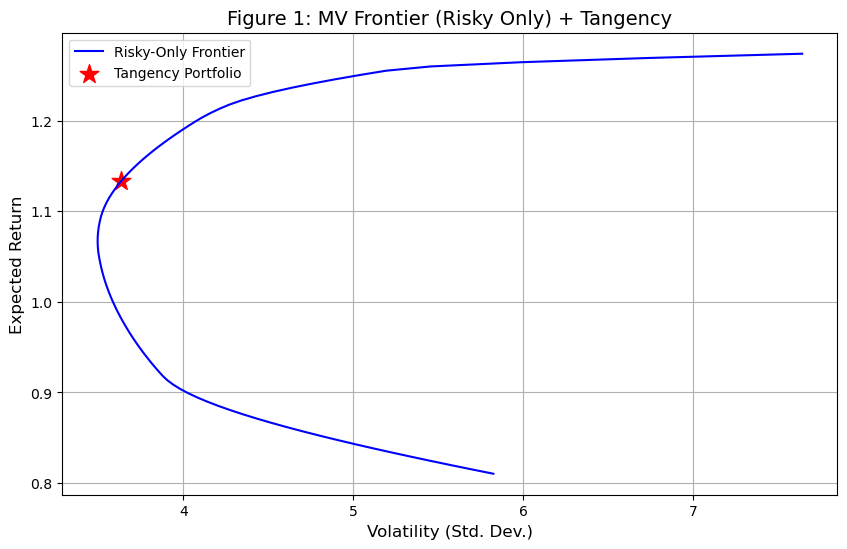

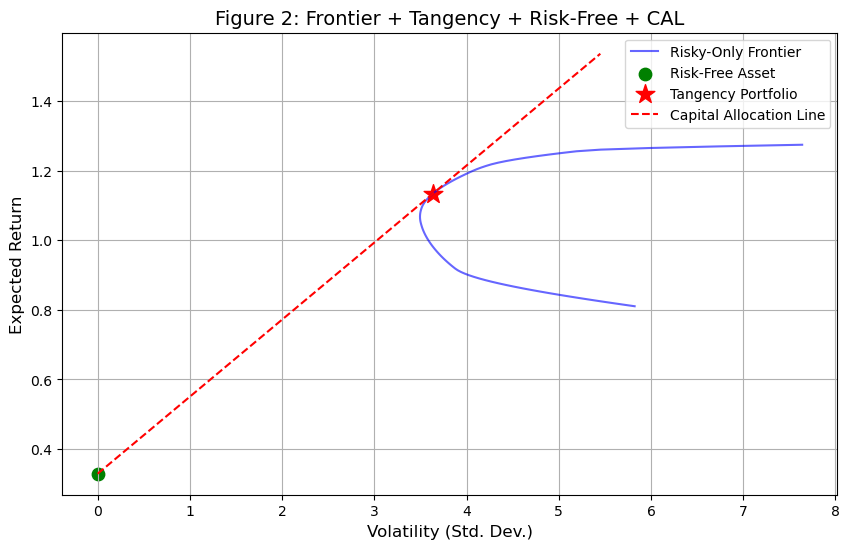

=== COMPARISON SUMMARY ===

Sample Period: 1980-01 to 2024-12
Risk-Free Rate Source: Fama–French Factors (Kenneth French Library)

1) Risky-Only Frontier (17 Industry Portfolios)
   - This is the classical minimum-variance frontier among the 17 industries.
   - Each point is a feasible portfolio of risky assets (no risk-free).
   - Has a curved shape in (Volatility, Return) space.

2) Frontier with RF (CAL)
   - Once a risk-free asset is introduced, the efficient frontier becomes a
     straight line (the Capital Allocation Line, or CAL) from the risk-free
     rate to the tangency portfolio (highest Sharpe ratio among the risky assets).
   - The CAL typically dominates the old curved frontier in risk–return space.
   - Any point on the CAL is a combination of the risk-free asset and the
     tangency portfolio.

=== Tangency Portfolio Details ===
  Mean Return : 1.1334
  Volatility  : 3.6341
  Sharpe Ratio: 0.2212

In conclusion, the introduction of a risk-free asset shifts the effici

In [14]:
import numpy as np
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt


# 1. LOAD INDUSTRY PORTFOLIOS & RISK-FREE RATE

df_ind = pd.read_csv("PortData.csv", index_col="Date", parse_dates=True)
df_ind = df_ind.loc["1980-01":"2024-12"]
df_ind.dropna(inplace=True)

# Example Fama–French factors file with columns: Date, Mkt-RF, SMB, HML, RMW, CMA, RF
df_ff = pd.read_csv("FFama.csv")
df_ff["Date"] = pd.to_datetime(df_ff["Date"].astype(str), format="%Y%m")
df_ff.set_index("Date", inplace=True)
df_ff.sort_index(inplace=True)

# Filter same period
df_ff = df_ff.loc["1980-01":"2024-12"].copy()
df_ff.dropna(inplace=True)

# The 'RF' column might be in percent or decimal. Adjust if needed.
# For example, if it's already in decimal (0.001 = 0.1%), do nothing:
risk_free_rate = df_ff["RF"].mean()
print(f"Average monthly RF from 1980-01 to 2024-12 = {risk_free_rate:.4f}")


# 2. SAMPLE ESTIMATES (MEANS & COVARIANCE)

mean_returns = df_ind.mean()
cov_matrix   = df_ind.cov()


# 3. RISKY-ONLY FRONTIER

def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    var = weights @ cov_matrix @ weights
    return ret, np.sqrt(var)

def minimize_variance(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1] ** 2

def constraint_sum(weights):
    return np.sum(weights) - 1

def target_return_constraint(weights, mean_returns, target_return):
    return np.dot(weights, mean_returns) - target_return

def compute_frontier(mu_vector, cov_matrix, n_points=100, short_allowed=False):
    """
    Creates a min-variance frontier by scanning from min to max of mu_vector.
    """
    ret_min, ret_max = mu_vector.min(), mu_vector.max()
    target_returns = np.linspace(ret_min, ret_max, n_points)

    frontier_risks = []
    frontier_returns = []

    if short_allowed:
        bounds = tuple((None, None) for _ in range(len(mu_vector)))
    else:
        bounds = tuple((0,1) for _ in range(len(mu_vector)))

    init_guess = np.ones(len(mu_vector)) / len(mu_vector)

    for tr in target_returns:
        constraints = (
            {'type': 'eq', 'fun': constraint_sum},
            {'type': 'eq', 'fun': target_return_constraint, 'args': (mu_vector, tr)}
        )
        res = sco.minimize(
            fun=minimize_variance,
            x0=init_guess,
            args=(mu_vector, cov_matrix),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        if res.success:
            frontier_risks.append(np.sqrt(res.fun))
            frontier_returns.append(tr)
        else:
            frontier_risks.append(np.nan)
            frontier_returns.append(tr)

    return np.array(frontier_risks), np.array(frontier_returns)

frontier_risks, frontier_returns = compute_frontier(mean_returns, cov_matrix, short_allowed=False)


# 4. TANGENCY PORTFOLIO WITH RISK-FREE RATE

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(ret - rf)/vol if vol > 1e-10 else 0.0

def find_tangency(mean_returns, cov_matrix, rf=0.0, short_allowed=False):
    n = len(mean_returns)
    if short_allowed:
        bounds = tuple((None, None) for _ in range(n))
    else:
        bounds = tuple((0,1) for _ in range(n))

    init_guess = np.ones(n)/n
    constraints = ({'type': 'eq', 'fun': constraint_sum},)

    result = sco.minimize(
        fun=negative_sharpe_ratio,
        x0=init_guess,
        args=(mean_returns, cov_matrix, rf),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    if result.success:
        w_opt = result.x
        ret_opt, vol_opt = portfolio_performance(w_opt, mean_returns, cov_matrix)
        return w_opt, ret_opt, vol_opt
    else:
        return None, None, None

w_tan, ret_tan, vol_tan = find_tangency(mean_returns, cov_matrix, rf=risk_free_rate, short_allowed=False)

# Calculate tangency Sharpe
if vol_tan is not None and vol_tan > 1e-12:
    sr_tan = (ret_tan - risk_free_rate) / vol_tan
else:
    sr_tan = np.nan

print("\nTangency Portfolio Weights:\n", w_tan)
print(f"Tangency Return = {ret_tan:.4f}, Tangency Vol = {vol_tan:.4f}, Sharpe = {sr_tan:.4f}")


# 5. FIGURE 1: RISKY-ONLY FRONTIER + TANGENCY POINT

plt.figure(figsize=(10, 6))

plt.plot(frontier_risks, frontier_returns, 'b-', label='Risky-Only Frontier')
if w_tan is not None:
    plt.scatter(vol_tan, ret_tan, color='red', marker='*', s=200, label='Tangency Portfolio')

plt.xlabel("Volatility (Std. Dev.)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.title("Figure 1: MV Frontier (Risky Only) + Tangency", fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.show()


# 6. FIGURE 2: FRONTIER + TANGENCY + RISK-FREE + CAL

plt.figure(figsize=(10, 6))

# 6A. Plot the original risky-only frontier in faint color
plt.plot(frontier_risks, frontier_returns, 'b-', alpha=0.6, label='Risky-Only Frontier')

# 6B. Mark the risk-free point (0 volatility, RF return)
plt.scatter(0.0, risk_free_rate, color='green', s=80, label='Risk-Free Asset')

# 6C. Mark the tangency portfolio
if w_tan is not None:
    plt.scatter(vol_tan, ret_tan, color='red', marker='*', s=200, label='Tangency Portfolio')

# 6D. Plot the capital allocation line (CAL) from 0 to some leverage
if w_tan is not None and vol_tan is not None:
    max_leverage = 1.5  # e.g., 150% investment in tangency portfolio
    cal_x = np.linspace(0, max_leverage, 50) * vol_tan
    cal_y = risk_free_rate + ((ret_tan - risk_free_rate)/vol_tan) * cal_x
    plt.plot(cal_x, cal_y, 'r--', label='Capital Allocation Line')

plt.xlabel("Volatility (Std. Dev.)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.title("Figure 2: Frontier + Tangency + Risk-Free + CAL", fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.show()


# 7. COMPARISON SUMMARY

def print_comparison_summary(
    start_date="1980-01", 
    end_date="2024-12",
    risk_free_source="Fama–French Factors",
    old_frontier_label="Risky-Only Frontier (17 Industries)",
    new_frontier_label="Frontier with Risk-Free (CAL)",
    tangency_info=None
):
    """
    Prints a textual summary comparing the old (risky-only) frontier
    to the new frontier (risk-free included), referencing the sample period
    and risk-free data source.
    
    :param start_date: The start of the sample period for the data (str).
    :param end_date:   The end of the sample period for the data (str).
    :param risk_free_source: Description of where the RF data came from.
    :param old_frontier_label: Name/description of the risky-only frontier.
    :param new_frontier_label: Name/description of the frontier with RF.
    :param tangency_info: (Optional) Dictionary with tangency portfolio stats
                          like {"return": 1.10, "vol": 3.50, "sharpe": 0.22}.
    """
    
    print("=== COMPARISON SUMMARY ===\n")
    print(f"Sample Period: {start_date} to {end_date}")
    print(f"Risk-Free Rate Source: {risk_free_source}\n")
    
    print(f"1) {old_frontier_label}")
    print("   - This is the classical minimum-variance frontier among the 17 industries.")
    print("   - Each point is a feasible portfolio of risky assets (no risk-free).")
    print("   - Has a curved shape in (Volatility, Return) space.\n")
    
    print(f"2) {new_frontier_label}")
    print("   - Once a risk-free asset is introduced, the efficient frontier becomes a")
    print("     straight line (the Capital Allocation Line, or CAL) from the risk-free")
    print("     rate to the tangency portfolio (highest Sharpe ratio among the risky assets).")
    print("   - The CAL typically dominates the old curved frontier in risk–return space.")
    print("   - Any point on the CAL is a combination of the risk-free asset and the")
    print("     tangency portfolio.\n")
    
    if tangency_info is not None:
        print("=== Tangency Portfolio Details ===")
        print(f"  Mean Return : {tangency_info.get('return', 'N/A'):.4f}")
        print(f"  Volatility  : {tangency_info.get('vol', 'N/A'):.4f}")
        print(f"  Sharpe Ratio: {tangency_info.get('sharpe', 'N/A'):.4f}\n")
    
    print("In conclusion, the introduction of a risk-free asset shifts the efficient set")
    print("from the old risky-only frontier to the CAL, anchored at the risk-free rate.")

# Build tangency stats dictionary
tangency_stats = {
    "return": ret_tan if ret_tan is not None else np.nan,
    "vol": vol_tan if vol_tan is not None else np.nan,
    "sharpe": sr_tan if sr_tan is not None else np.nan
}

print_comparison_summary(
    start_date="1980-01", 
    end_date="2024-12",
    risk_free_source="Fama–French Factors (Kenneth French Library)",
    old_frontier_label="Risky-Only Frontier (17 Industry Portfolios)",
    new_frontier_label="Frontier with RF (CAL)",
    tangency_info=tangency_stats
)

QUESTION 5 Fama–French Factor Mimicking vs. Industry Portfolios


===== Portfolio Performance (Excess Returns, No Short Selling) =====
 Dataset Portfolio Type  Mean Excess Return  Volatility  Sharpe Ratio
Industry       Tangency              0.8035      3.6237        0.2217
     FF3       Tangency              0.4914      2.6183        0.1877
     FF5       Tangency              0.3854      1.2055        0.3197
Industry            GMV              0.7384      3.4868        0.2118
     FF3            GMV              0.2283      1.8094        0.1262
     FF5            GMV              0.3103      1.0817        0.2869


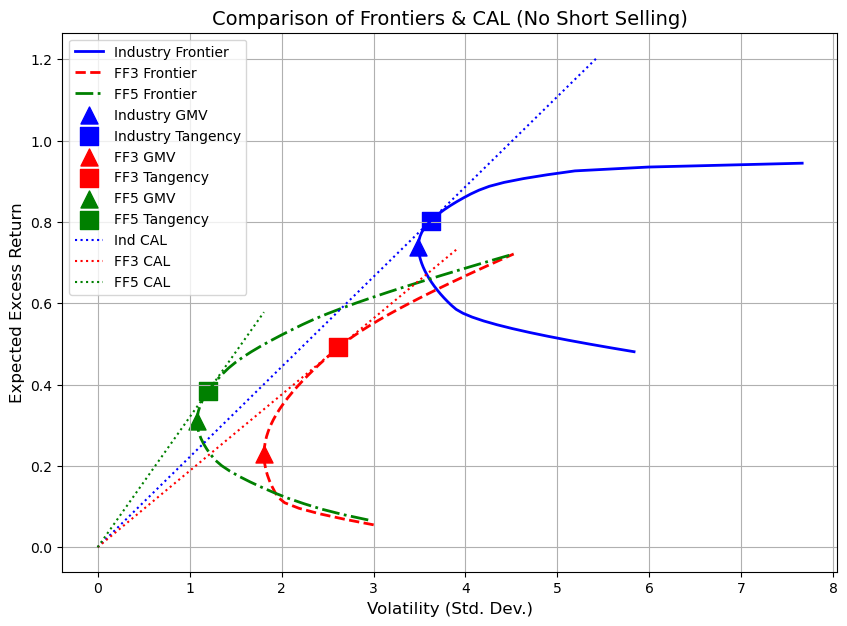

In [18]:
import numpy as np
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt


# (A) Load Industry Portfolio Data (raw returns) for 1980-01 to 2024-12
df_ind = pd.read_csv("PortData.csv", index_col="Date", parse_dates=True)
df_ind = df_ind.sort_index()
df_ind = df_ind.loc["1980-01":"2024-12"]

# (B) Load Fama–French 3-Factor data
#     Expected columns: [Date, Mkt-RF, SMB, HML, RF]
df_ff3 = pd.read_csv("FFama3.csv")
df_ff3["Date"] = pd.to_datetime(df_ff3["Date"], format="%Y%m")
df_ff3.set_index("Date", inplace=True)
df_ff3.sort_index(inplace=True)
df_ff3 = df_ff3.loc["1980-01":"2024-12"]

# (C) Load Fama–French 5-Factor data
#     Expected columns: [Date, Mkt-RF, SMB, HML, RMW, CMA, RF]
df_ff5 = pd.read_csv("FFama5.csv")
df_ff5["Date"] = pd.to_datetime(df_ff5["Date"], format="%Y%m")
df_ff5.set_index("Date", inplace=True)
df_ff5.sort_index(inplace=True)
df_ff5 = df_ff5.loc["1980-01":"2024-12"]

# (D) Align all three dataframes to a common index (intersection)
common_index = df_ind.index.intersection(df_ff3.index).intersection(df_ff5.index)
df_ind = df_ind.loc[common_index].dropna()
df_ff3 = df_ff3.loc[common_index].dropna()
df_ff5 = df_ff5.loc[common_index].dropna()

##############################################################################
# 2. PREPARE DATA (EXCESS RETURNS USING MONTHLY RF)
##############################################################################
# Now we subtract the actual monthly RF from each row of the industry returns.
# Make sure 'RF' in df_ff3 and df_ff5 is in decimal form, not in percent.
# If 'RF' is in percent (e.g., 0.10 for 10 bps), divide by 100.

# Confirm or convert if needed:
# df_ff3["RF"] = df_ff3["RF"] / 100.0
# df_ff5["RF"] = df_ff5["RF"] / 100.0

# (A) Convert Industry Data to EXCESS returns by subtracting matching monthly RF
df_ind_excess = df_ind.sub(df_ff3["RF"], axis=0)

# (B) For FF3, select the factor columns (already in excess returns, e.g., Mkt-RF)
df_ff3_factors = df_ff3[["Mkt-RF", "SMB", "HML"]]

# (C) For FF5, select the factor columns (already in excess returns)
df_ff5_factors = df_ff5[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]


def portfolio_performance(weights, mean_returns, cov_matrix, rf=0.0):
    """
    Given weights, mean returns (already in EXCESS form), and covariance,
    returns (ret, vol, sr).
    'ret' is the portfolio's EXCESS return,
    'vol' is standard deviation,
    'sr' is Sharpe ratio = (ret - rf) / vol, but typically rf=0 in EXCESS space.
    """
    ret = np.dot(weights, mean_returns)
    var = weights @ cov_matrix @ weights
    vol = np.sqrt(var)
    excess_ret = ret - rf
    sr = excess_ret / vol if vol > 1e-12 else 0.0
    return ret, vol, sr

def constraint_sum(weights):
    """Constraint that sum of weights == 1."""
    return np.sum(weights) - 1

def minimize_variance(weights, mean_returns, cov_matrix):
    """Objective function: minimize portfolio variance."""
    return portfolio_performance(weights, mean_returns, cov_matrix, rf=0.0)[1]**2

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf=0.0):
    """
    Objective function for tangency portfolio:
    We want to maximize Sharpe => minimize negative Sharpe.
    """
    _, _, sr = portfolio_performance(weights, mean_returns, cov_matrix, rf=rf)
    return -sr

def find_gmv(mean_returns, cov_matrix):
    """Find Global Minimum Variance (GMV) portfolio with no short selling."""
    n = len(mean_returns)
    bounds = [(0,1)] * n
    constraints = [{'type': 'eq', 'fun': constraint_sum}]
    init_guess = np.ones(n)/n

    res = sco.minimize(
        fun=minimize_variance,
        x0=init_guess,
        args=(mean_returns, cov_matrix),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return res.x if res.success else None

def find_tangency(mean_returns, cov_matrix):
    """Find tangency (max Sharpe) portfolio with no short selling."""
    n = len(mean_returns)
    bounds = [(0,1)] * n
    constraints = [{'type': 'eq', 'fun': constraint_sum}]
    init_guess = np.ones(n)/n

    res = sco.minimize(
        fun=negative_sharpe_ratio,
        x0=init_guess,
        args=(mean_returns, cov_matrix, 0.0),  # rf=0.0 in EXCESS space
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return res.x if res.success else None

def compute_frontier(mu_vector, cov_matrix, n_points=50):
    """
    Computes an efficient frontier by scanning from min to max average return
    with no short selling. Returns arrays of (frontier_risks, frontier_returns).
    """
    min_ret, max_ret = mu_vector.min(), mu_vector.max()
    target_returns = np.linspace(min_ret, max_ret, n_points)
    n = len(mu_vector)
    bounds = [(0,1)] * n
    init_guess = np.ones(n)/n

    frontier_risks = []
    frontier_returns = []

    def target_ret_constraint(w, mu, tr):
        return np.dot(w, mu) - tr

    for tr in target_returns:
        constraints = (
            {'type': 'eq', 'fun': constraint_sum},
            {'type': 'eq', 'fun': target_ret_constraint, 'args': (mu_vector, tr)}
        )
        res = sco.minimize(
            fun=minimize_variance,
            x0=init_guess,
            args=(mu_vector, cov_matrix),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        if res.success:
            # res.fun is the minimized variance
            frontier_risks.append(np.sqrt(res.fun))
            frontier_returns.append(tr)
        else:
            frontier_risks.append(np.nan)
            frontier_returns.append(tr)

    return np.array(frontier_risks), np.array(frontier_returns)


# 4. SAMPLE STATISTICS & FRONTIER COMPUTATION

# (A) Industry (EXCESS)
mu_ind = df_ind_excess.mean()
cov_ind = df_ind_excess.cov()

# (B) FF3
mu_ff3 = df_ff3_factors.mean()
cov_ff3 = df_ff3_factors.cov()

# (C) FF5
mu_ff5 = df_ff5_factors.mean()
cov_ff5 = df_ff5_factors.cov()

# Compute frontiers
risks_ind, rets_ind = compute_frontier(mu_ind, cov_ind, n_points=50)
risks_ff3, rets_ff3 = compute_frontier(mu_ff3, cov_ff3, n_points=50)
risks_ff5, rets_ff5 = compute_frontier(mu_ff5, cov_ff5, n_points=50)

# Compute GMV & Tangency
w_gmv_ind = find_gmv(mu_ind, cov_ind)
w_tan_ind = find_tangency(mu_ind, cov_ind)

w_gmv_ff3 = find_gmv(mu_ff3, cov_ff3)
w_tan_ff3 = find_tangency(mu_ff3, cov_ff3)

w_gmv_ff5 = find_gmv(mu_ff5, cov_ff5)
w_tan_ff5 = find_tangency(mu_ff5, cov_ff5)


# 5. DISPLAY RESULTS IN TABLES

results = {
    "Dataset": [],
    "Portfolio Type": [],
    "Mean Excess Return": [],
    "Volatility": [],
    "Sharpe Ratio": []
}

def record_portfolio(dataset_label, port_type, w, mu, cov):
    if w is None:
        # In case optimization fails
        results["Dataset"].append(dataset_label)
        results["Portfolio Type"].append(port_type)
        results["Mean Excess Return"].append(np.nan)
        results["Volatility"].append(np.nan)
        results["Sharpe Ratio"].append(np.nan)
    else:
        ret, vol, sr = portfolio_performance(w, mu, cov, rf=0.0)
        results["Dataset"].append(dataset_label)
        results["Portfolio Type"].append(port_type)
        results["Mean Excess Return"].append(ret)
        results["Volatility"].append(vol)
        results["Sharpe Ratio"].append(sr)

# Record tangency + GMV for each dataset
record_portfolio("Industry", "Tangency", w_tan_ind, mu_ind, cov_ind)
record_portfolio("FF3", "Tangency", w_tan_ff3, mu_ff3, cov_ff3)
record_portfolio("FF5", "Tangency", w_tan_ff5, mu_ff5, cov_ff5)

record_portfolio("Industry", "GMV", w_gmv_ind, mu_ind, cov_ind)
record_portfolio("FF3", "GMV", w_gmv_ff3, mu_ff3, cov_ff3)
record_portfolio("FF5", "GMV", w_gmv_ff5, mu_ff5, cov_ff5)

df_results = pd.DataFrame(results)
df_results["Mean Excess Return"] = df_results["Mean Excess Return"].round(4)
df_results["Volatility"] = df_results["Volatility"].round(4)
df_results["Sharpe Ratio"] = df_results["Sharpe Ratio"].round(4)

print("\n===== Portfolio Performance (Excess Returns, No Short Selling) =====")
print(df_results.to_string(index=False))


# 6. PLOT FRONTIERS + GMV + TANGENCY + CAL

plt.figure(figsize=(10, 7))

# Plot the frontiers
plt.plot(risks_ind, rets_ind, 'b-', lw=2, label='Industry Frontier')
plt.plot(risks_ff3, rets_ff3, 'r--', lw=2, label='FF3 Frontier')
plt.plot(risks_ff5, rets_ff5, 'g-.', lw=2, label='FF5 Frontier')

def plot_portfolio_point(weights, mu, cov, marker, color, label):
    """Scatter-plot a single portfolio point (vol, ret)."""
    if weights is not None:
        ret, vol, _ = portfolio_performance(weights, mu, cov, rf=0.0)
        plt.scatter(vol, ret, marker=marker, color=color, s=150, label=label)

# Mark GMV & Tangency
plot_portfolio_point(w_gmv_ind, mu_ind, cov_ind, '^', 'blue', 'Industry GMV')
plot_portfolio_point(w_tan_ind, mu_ind, cov_ind, 's', 'blue', 'Industry Tangency')

plot_portfolio_point(w_gmv_ff3, mu_ff3, cov_ff3, '^', 'red', 'FF3 GMV')
plot_portfolio_point(w_tan_ff3, mu_ff3, cov_ff3, 's', 'red', 'FF3 Tangency')

plot_portfolio_point(w_gmv_ff5, mu_ff5, cov_ff5, '^', 'green', 'FF5 GMV')
plot_portfolio_point(w_tan_ff5, mu_ff5, cov_ff5, 's', 'green', 'FF5 Tangency')

# Plot the CAL lines from (0,0) in EXCESS space to the tangency points
def plot_cal_line(ret_tan, vol_tan, color, label, max_leverage=1.5):
    """
    In EXCESS return space, risk-free is (0,0).
    We draw a line from (0,0) to some multiple of (vol_tan, ret_tan).
    """
    if vol_tan is None or vol_tan < 1e-12:
        return
    xvals = np.linspace(0, max_leverage * vol_tan, 50)
    slope = ret_tan / vol_tan
    yvals = slope * xvals
    plt.plot(xvals, yvals, color=color, linestyle=':', label=label)

def get_ret_vol(weights, mu, cov):
    if weights is None:
        return None, None
    r, v, _ = portfolio_performance(weights, mu, cov, rf=0.0)
    return r, v

# Industry tangency
r_ind, v_ind = get_ret_vol(w_tan_ind, mu_ind, cov_ind)
plot_cal_line(r_ind, v_ind, 'blue', 'Ind CAL')

# FF3 tangency
r_ff3, v_ff3 = get_ret_vol(w_tan_ff3, mu_ff3, cov_ff3)
plot_cal_line(r_ff3, v_ff3, 'red', 'FF3 CAL')

# FF5 tangency
r_ff5, v_ff5 = get_ret_vol(w_tan_ff5, mu_ff5, cov_ff5)
plot_cal_line(r_ff5, v_ff5, 'green', 'FF5 CAL')

plt.xlabel("Volatility (Std. Dev.)", fontsize=12)
plt.ylabel("Expected Excess Return", fontsize=12)
plt.title("Comparison of Frontiers & CAL (No Short Selling)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


QUESTION 6 Practical Proxies for Fama–French Factors

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. DEFINE TICKERS & DATE RANGE

tickers = {
    'Market': 'VFINX',
    'Small': 'VEXPX',
    'Value': 'VWNDX',
    'Growth': 'PRGFX',
    'Quality': 'AWSHX',
    'Conservative': 'VWINX',
    'Aggressive': 'FMAGX'
}

start_date = '1980-01-01'
end_date   = '2024-12-31'


# 2. DOWNLOAD DAILY PRICE DATA

dfs = []
for label, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Prefer 'Adj Close' if available
    if 'Adj Close' in df.columns:
        df = df[['Adj Close']].copy()
        df.rename(columns={'Adj Close': label}, inplace=True)
    else:
        df = df[['Close']].copy()
        df.rename(columns={'Close': label}, inplace=True)
    
    dfs.append(df)

# Merge all tickers into one DataFrame on Date index
df_merged = pd.concat(dfs, axis=1, join='inner').dropna(how='all')


if isinstance(df_merged.columns, pd.MultiIndex):
    df_merged.columns = df_merged.columns.droplevel(level=1)


# 3. RESAMPLE TO MONTHLY & COMPUTE DECIMAL MONTHLY RETURNS

monthly_prices = df_merged.resample('ME').last()  # last trading day each month
monthly_returns_total = monthly_prices.pct_change().dropna()  # decimal monthly returns

# Quick check
print("MONTHLY PRICES")
print(monthly_prices.head())
print("\nMONTHLY TOTAL RETURNS")
print(monthly_returns_total.head())


# 4. LOAD FAMA-FRENCH DATA (FOR RF), ENSURE MONTHLY & DECIMAL

ff_data = pd.read_csv('FFama5.csv', index_col=0)
# Typically, Fama-French uses a YYYYMM format index, e.g. "192607"
ff_data.index = pd.to_datetime(ff_data.index, format='%Y%m')


ff_data.rename(columns={'RF': 'RF_percent'}, inplace=True)
ff_data['RF'] = ff_data['RF_percent'] / 100.0

rf_aligned = ff_data['RF'].reindex(monthly_returns_total.index, method='ffill').dropna()


print("\n===== ALIGNED RF (head) =====")
print(rf_aligned.head())


# 5. COMPUTE EXCESS RETURNS (TOTAL - RF)

monthly_returns_excess = monthly_returns_total.sub(rf_aligned, axis=0)


print("\nMONTHLY EXCESS RETURNS")
print(monthly_returns_excess.head())

mean_excess = monthly_returns_excess.mean() * 100  # convert to percent for readability
print("\nAVERAGE EXCESS RETURNS")
print(mean_excess)


YF.download() has changed argument auto_adjust default to True
MONTHLY PRICES
Price         Market     Small     Value    Growth   Quality  Conservative  \
Date                                                                         
1980-01-31  4.848053  2.105867  0.280400  1.918671  0.623022      0.431829   
1980-02-29  4.866808  2.066653  0.270148  1.891422  0.607555      0.407969   
1980-03-31  4.390318  1.783681  0.248813  1.737543  0.549979      0.399947   
1980-04-30  4.580101  1.848330  0.259952  1.790440  0.537524      0.438419   
1980-05-31  4.833151  1.971270  0.280692  1.886614  0.570022      0.460059   

Price       Aggressive  
Date                    
1980-01-31    0.098671  
1980-02-29    0.099061  
1980-03-31    0.085690  
1980-04-30    0.092089  
1980-05-31    0.100134  

MONTHLY TOTAL RETURNS
Price         Market     Small     Value    Growth   Quality  Conservative  \
Date                                                                         
1980-02-29  0.003869 

C:\Users\Dell\AppData\Local\Temp\ipykernel_28260\3674915328.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = df_merged.resample('M').last()



===== Factor Proxies (head) =====
Price            SMB       HML       RMW       CMA
Date                                              
1980-02-29 -0.022490 -0.022360 -0.033727 -0.059205
1980-03-31 -0.039017  0.002382 -0.106867  0.115319
1980-04-30 -0.006983  0.014326 -0.035245  0.021511
1980-05-31  0.011264  0.026066  0.052358 -0.038000
1980-06-30  0.006446 -0.001234  0.017012 -0.051221


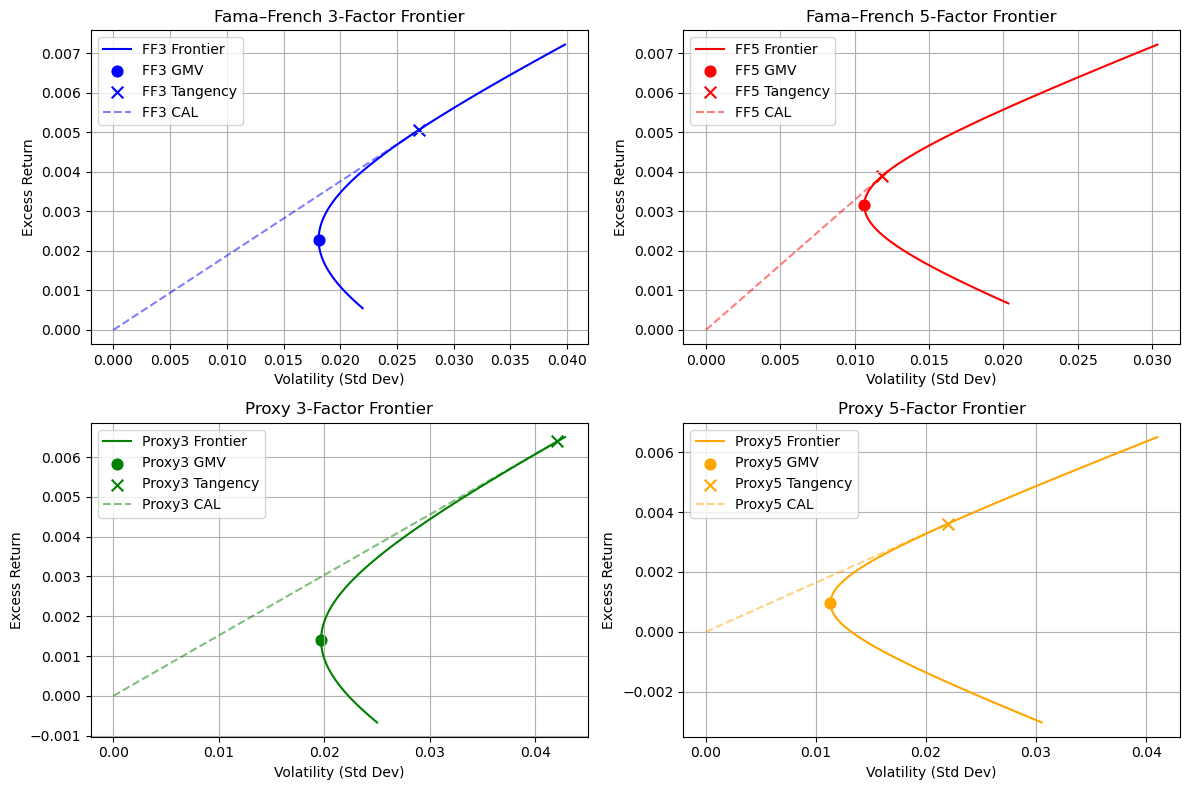

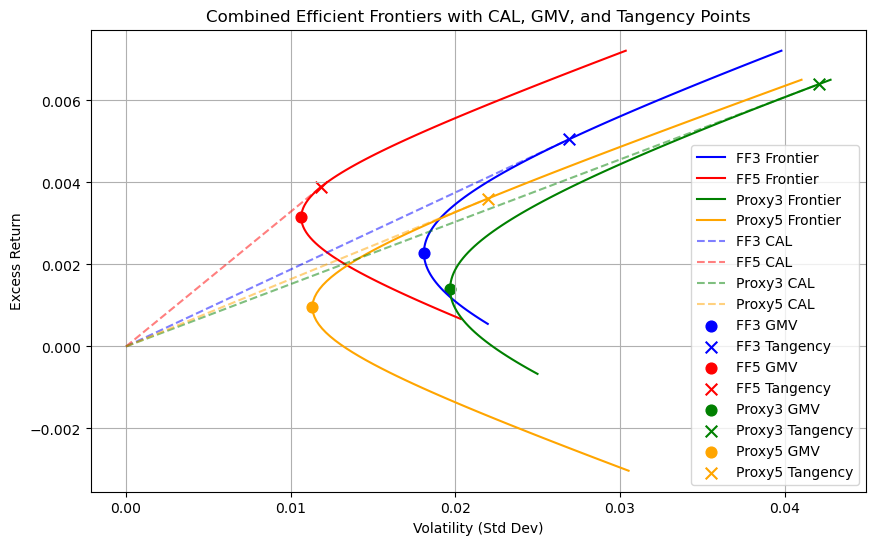


===== Final Portfolio Results =====
               Model  GMV Return  GMV Vol  GMV Sharpe  Tangency Return  Tangency Vol  Tangency Sharpe
FAMA-FRENCH 3 FACTOR    0.002283 0.018094    0.126180         0.005055      0.026924         0.187760
FAMA-FRENCH 5 FACTOR    0.003148 0.010643    0.295783         0.003884      0.011822         0.328538
      PROXY 3 FACTOR    0.001400 0.019683    0.071109         0.006397      0.042079         0.152018
      PROXY 5 FACTOR    0.000957 0.011322    0.084524         0.003608      0.021983         0.164122


In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


tickers = {
    'Market': 'VFINX',
    'Small': 'VEXPX',
    'Value': 'VWNDX',
    'Growth': 'PRGFX',
    'Quality': 'AWSHX',
    'Conservative': 'VWINX',
    'Aggressive': 'FMAGX'
}

start_date = '1980-01-01'
end_date   = '2024-12-31'

dfs = []
for label, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if 'Adj Close' in df.columns:
        df = df[['Adj Close']].copy()
        df.rename(columns={'Adj Close': label}, inplace=True)
    else:
        df = df[['Close']].copy()
        df.rename(columns={'Close': label}, inplace=True)
    dfs.append(df)

df_merged = pd.concat(dfs, axis=1, join='inner').dropna(how='all')
if isinstance(df_merged.columns, pd.MultiIndex):
    df_merged.columns = df_merged.columns.droplevel(level=1)

monthly_prices = df_merged.resample('M').last()
monthly_returns_total = monthly_prices.pct_change().dropna()


# Load FFama3.csv for the official 3-factor data
ff3_data = pd.read_csv("FFama3.csv")
ff3_data["Date"] = pd.to_datetime(ff3_data["Date"], format="%Y%m")
ff3_data.set_index("Date", inplace=True)
ff3_data.sort_index(inplace=True)
ff3_data = ff3_data.loc["1980-01":"2024-12"].dropna()

# Convert RF from percent to decimal (if needed) and rename column
ff3_data.rename(columns={'RF': 'RF_percent'}, inplace=True)
ff3_data['RF'] = ff3_data['RF_percent'] / 100.0

# Convert factor returns to decimals if they are in percentage terms
factor_cols_ff3 = ['Mkt-RF', 'SMB', 'HML']
for col in factor_cols_ff3:
    if ff3_data[col].max() > 1:
        ff3_data[col] = ff3_data[col] / 100.0

# Load FFama5.csv for the official 5-factor data
ff5_data = pd.read_csv("FFama5.csv")
ff5_data["Date"] = pd.to_datetime(ff5_data["Date"], format="%Y%m")
ff5_data.set_index("Date", inplace=True)
ff5_data.sort_index(inplace=True)
ff5_data = ff5_data.loc["1980-01":"2024-12"].dropna()

ff5_data.rename(columns={'RF': 'RF_percent'}, inplace=True)
ff5_data['RF'] = ff5_data['RF_percent'] / 100.0

# Convert factor returns for FF5 to decimals if they are in percentage terms
factor_cols_ff5 = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
for col in factor_cols_ff5:
    if ff5_data[col].max() > 1:
        ff5_data[col] = ff5_data[col] / 100.0

# Align risk-free rate (from FFama5) to our monthly returns index
rf_aligned = ff5_data['RF'].reindex(monthly_returns_total.index, method='ffill').dropna()
monthly_returns_excess = monthly_returns_total.sub(rf_aligned, axis=0)


factor_proxies = monthly_returns_excess.copy()
factor_proxies['SMB'] = factor_proxies['Small'] - factor_proxies['Market']
factor_proxies['HML'] = factor_proxies['Value'] - factor_proxies['Growth']

factor_proxies['RMW'] = factor_proxies['Quality']
factor_proxies['CMA'] = factor_proxies['Conservative'] - factor_proxies['Aggressive']

proxy3 = factor_proxies[['Market', 'SMB', 'HML']].dropna()
proxy5 = factor_proxies[['Market', 'SMB', 'HML', 'RMW', 'CMA']].dropna()

print("\n===== Factor Proxies (head) =====")
print(factor_proxies[['SMB','HML','RMW','CMA']].head())


def portfolio_stats(weights, mean_returns, cov_matrix):
    port_ret = weights.dot(mean_returns)
    port_vol = np.sqrt(weights.dot(cov_matrix).dot(weights))
    return port_ret, port_vol

def global_min_variance(cov_matrix):
    K = cov_matrix.shape[0]
    ones = np.ones(K)
    inv_cov = np.linalg.inv(cov_matrix)
    w_gmv = inv_cov.dot(ones) / (ones.T.dot(inv_cov).dot(ones))
    return w_gmv

def tangency_portfolio(mean_returns, cov_matrix):
    K = cov_matrix.shape[0]
    inv_cov = np.linalg.inv(cov_matrix)
    ones = np.ones(K)
    w_tan = inv_cov.dot(mean_returns) / (ones.T.dot(inv_cov).dot(mean_returns))
    return w_tan

def efficient_frontier(mean_returns, cov_matrix, points=100):
    K = len(mean_returns)
    inv_cov = np.linalg.inv(cov_matrix)
    ones = np.ones(K)
    bounds = [(0, 1)] * len(mean_returns)  # Restricts weights to 0-100% (long-only)
    A = ones.T.dot(inv_cov).dot(ones)
    B = mean_returns.T.dot(inv_cov).dot(ones)
    C = mean_returns.T.dot(inv_cov).dot(mean_returns)
    
    mu_min = min(mean_returns)
    mu_max = max(mean_returns)
    target_returns = np.linspace(mu_min, mu_max, points)
    
    data = []
    for mu_t in target_returns:
        M = np.array([[A, B],
                      [B, C]])
        rhs = np.array([1, mu_t])
        alpha, beta = np.linalg.solve(M, rhs)
        
        w = alpha * inv_cov.dot(ones) + beta * inv_cov.dot(mean_returns)
        port_ret, port_vol = portfolio_stats(w, mean_returns, cov_matrix)
        data.append((port_ret, port_vol))
    
    return pd.DataFrame(data, columns=['Return','Volatility'])

def sharpe_ratio(port_return, port_vol):
    # Since returns are in excess (rf = 0)
    return port_return / port_vol



ff3 = ff3_data[['Mkt-RF','SMB','HML']].dropna()

ff5 = ff5_data[['Mkt-RF','SMB','HML','RMW','CMA']].dropna()

# 5a. PROXY3
mean_p3 = proxy3.mean().values
cov_p3  = proxy3.cov().values
w_gmv_p3 = global_min_variance(cov_p3)
gmv_ret_p3, gmv_vol_p3 = portfolio_stats(w_gmv_p3, mean_p3, cov_p3)
w_tan_p3 = tangency_portfolio(mean_p3, cov_p3)
tan_ret_p3, tan_vol_p3 = portfolio_stats(w_tan_p3, mean_p3, cov_p3)
front_p3 = efficient_frontier(mean_p3, cov_p3)

# 5b. PROXY5
mean_p5 = proxy5.mean().values
cov_p5  = proxy5.cov().values
w_gmv_p5 = global_min_variance(cov_p5)
gmv_ret_p5, gmv_vol_p5 = portfolio_stats(w_gmv_p5, mean_p5, cov_p5)
w_tan_p5 = tangency_portfolio(mean_p5, cov_p5)
tan_ret_p5, tan_vol_p5 = portfolio_stats(w_tan_p5, mean_p5, cov_p5)
front_p5 = efficient_frontier(mean_p5, cov_p5)

# 5c. OFFICIAL FF3
mean_ff3 = ff3.mean().values
cov_ff3  = ff3.cov().values
w_gmv_ff3 = global_min_variance(cov_ff3)
gmv_ret_ff3, gmv_vol_ff3 = portfolio_stats(w_gmv_ff3, mean_ff3, cov_ff3)
w_tan_ff3 = tangency_portfolio(mean_ff3, cov_ff3)
tan_ret_ff3, tan_vol_ff3 = portfolio_stats(w_tan_ff3, mean_ff3, cov_ff3)
front_ff3 = efficient_frontier(mean_ff3, cov_ff3)

# 5d. OFFICIAL FF5
mean_ff5 = ff5.mean().values
cov_ff5  = ff5.cov().values
w_gmv_ff5 = global_min_variance(cov_ff5)
gmv_ret_ff5, gmv_vol_ff5 = portfolio_stats(w_gmv_ff5, mean_ff5, cov_ff5)
w_tan_ff5 = tangency_portfolio(mean_ff5, cov_ff5)
tan_ret_ff5, tan_vol_ff5 = portfolio_stats(w_tan_ff5, mean_ff5, cov_ff5)
front_ff5 = efficient_frontier(mean_ff5, cov_ff5)


def plot_frontier(ax, frontier_df, gmv_vol, gmv_ret, tan_vol, tan_ret, color, label_prefix):
    ax.plot(frontier_df['Volatility'], frontier_df['Return'],
            color=color, label=f'{label_prefix} Frontier')
    # Plot GMV point
    ax.scatter(gmv_vol, gmv_ret, c=color, marker='o', s=60, label=f'{label_prefix} GMV')
    # Plot Tangency point
    ax.scatter(tan_vol, tan_ret, c=color, marker='x', s=70, label=f'{label_prefix} Tangency')
    # Plot CAL (Capital Allocation Line)
    x_cal = np.linspace(0, tan_vol, 100)
    y_cal = (tan_ret / tan_vol) * x_cal  # slope equals Sharpe ratio
    ax.plot(x_cal, y_cal, color=color, linestyle='--', alpha=0.5, label=f'{label_prefix} CAL')
    ax.set_xlabel('Volatility (Std Dev)')
    ax.set_ylabel('Excess Return')
    ax.legend(loc='best')
    ax.grid(True)


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Subplot (0,0) => FF3
plot_frontier(
    ax=axes[0,0],
    frontier_df=front_ff3,
    gmv_vol=gmv_vol_ff3,
    gmv_ret=gmv_ret_ff3,
    tan_vol=tan_vol_ff3,
    tan_ret=tan_ret_ff3,
    color='blue',
    label_prefix='FF3'
)
axes[0,0].set_title('Fama–French 3-Factor Frontier')

# Subplot (0,1) => FF5
plot_frontier(
    ax=axes[0,1],
    frontier_df=front_ff5,
    gmv_vol=gmv_vol_ff5,
    gmv_ret=gmv_ret_ff5,
    tan_vol=tan_vol_ff5,
    tan_ret=tan_ret_ff5,
    color='red',
    label_prefix='FF5'
)
axes[0,1].set_title('Fama–French 5-Factor Frontier')

# Subplot (1,0) => Proxy3
plot_frontier(
    ax=axes[1,0],
    frontier_df=front_p3,
    gmv_vol=gmv_vol_p3,
    gmv_ret=gmv_ret_p3,
    tan_vol=tan_vol_p3,
    tan_ret=tan_ret_p3,
    color='green',
    label_prefix='Proxy3'
)
axes[1,0].set_title('Proxy 3-Factor Frontier')

# Subplot (1,1) => Proxy5
plot_frontier(
    ax=axes[1,1],
    frontier_df=front_p5,
    gmv_vol=gmv_vol_p5,
    gmv_ret=gmv_ret_p5,
    tan_vol=tan_vol_p5,
    tan_ret=tan_ret_p5,
    color='orange',
    label_prefix='Proxy5'
)
axes[1,1].set_title('Proxy 5-Factor Frontier')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
# Plot frontiers
plt.plot(front_ff3['Volatility'], front_ff3['Return'], 'b-', label='FF3 Frontier')
plt.plot(front_ff5['Volatility'], front_ff5['Return'], 'r-', label='FF5 Frontier')
plt.plot(front_p3['Volatility'], front_p3['Return'], 'g-', label='Proxy3 Frontier')
plt.plot(front_p5['Volatility'], front_p5['Return'], color='orange', label='Proxy5 Frontier')

# Plot CAL lines for each model:
# FF3 CAL
x_cal = np.linspace(0, tan_vol_ff3, 100)
y_cal = (tan_ret_ff3 / tan_vol_ff3) * x_cal
plt.plot(x_cal, y_cal, 'b--', alpha=0.5, label='FF3 CAL')
# FF5 CAL
x_cal = np.linspace(0, tan_vol_ff5, 100)
y_cal = (tan_ret_ff5 / tan_vol_ff5) * x_cal
plt.plot(x_cal, y_cal, 'r--', alpha=0.5, label='FF5 CAL')
# Proxy3 CAL
x_cal = np.linspace(0, tan_vol_p3, 100)
y_cal = (tan_ret_p3 / tan_vol_p3) * x_cal
plt.plot(x_cal, y_cal, 'g--', alpha=0.5, label='Proxy3 CAL')
# Proxy5 CAL
x_cal = np.linspace(0, tan_vol_p5, 100)
y_cal = (tan_ret_p5 / tan_vol_p5) * x_cal
plt.plot(x_cal, y_cal, color='orange', linestyle='--', alpha=0.5, label='Proxy5 CAL')

# Mark GMV and Tangency points for each model
# FF3 points
plt.scatter(gmv_vol_ff3, gmv_ret_ff3, c='blue', marker='o', s=60, label='FF3 GMV')
plt.scatter(tan_vol_ff3, tan_ret_ff3, c='blue', marker='x', s=70, label='FF3 Tangency')
# FF5 points
plt.scatter(gmv_vol_ff5, gmv_ret_ff5, c='red', marker='o', s=60, label='FF5 GMV')
plt.scatter(tan_vol_ff5, tan_ret_ff5, c='red', marker='x', s=70, label='FF5 Tangency')
# Proxy3 points
plt.scatter(gmv_vol_p3, gmv_ret_p3, c='green', marker='o', s=60, label='Proxy3 GMV')
plt.scatter(tan_vol_p3, tan_ret_p3, c='green', marker='x', s=70, label='Proxy3 Tangency')
# Proxy5 points
plt.scatter(gmv_vol_p5, gmv_ret_p5, c='orange', marker='o', s=60, label='Proxy5 GMV')
plt.scatter(tan_vol_p5, tan_ret_p5, c='orange', marker='x', s=70, label='Proxy5 Tangency')

plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Excess Return')
plt.title('Combined Efficient Frontiers with CAL, GMV, and Tangency Points')
plt.legend()
plt.grid(True)
plt.show()


results_data = [
    {
        "Model": "FAMA-FRENCH 3 FACTOR",
        "GMV Return": gmv_ret_ff3,
        "GMV Vol": gmv_vol_ff3,
        "GMV Sharpe": sharpe_ratio(gmv_ret_ff3, gmv_vol_ff3),
        "Tangency Return": tan_ret_ff3,
        "Tangency Vol": tan_vol_ff3,
        "Tangency Sharpe": sharpe_ratio(tan_ret_ff3, tan_vol_ff3)
    },
    {
        "Model": "FAMA-FRENCH 5 FACTOR",
        "GMV Return": gmv_ret_ff5,
        "GMV Vol": gmv_vol_ff5,
        "GMV Sharpe": sharpe_ratio(gmv_ret_ff5, gmv_vol_ff5),
        "Tangency Return": tan_ret_ff5,
        "Tangency Vol": tan_vol_ff5,
        "Tangency Sharpe": sharpe_ratio(tan_ret_ff5, tan_vol_ff5)
    },
    {
        "Model": "PROXY 3 FACTOR",
        "GMV Return": gmv_ret_p3,
        "GMV Vol": gmv_vol_p3,
        "GMV Sharpe": sharpe_ratio(gmv_ret_p3, gmv_vol_p3),
        "Tangency Return": tan_ret_p3,
        "Tangency Vol": tan_vol_p3,
        "Tangency Sharpe": sharpe_ratio(tan_ret_p3, tan_vol_p3)
    },
    {
        "Model": "PROXY 5 FACTOR",
        "GMV Return": gmv_ret_p5,
        "GMV Vol": gmv_vol_p5,
        "GMV Sharpe": sharpe_ratio(gmv_ret_p5, gmv_vol_p5),
        "Tangency Return": tan_ret_p5,
        "Tangency Vol": tan_vol_p5,
        "Tangency Sharpe": sharpe_ratio(tan_ret_p5, tan_vol_p5)
    }
]

df_results = pd.DataFrame(results_data)
pd.set_option('display.float_format', lambda x: f"{x:0.6f}")

print("\n===== Final Portfolio Results =====")
print(df_results.to_string(index=False))


QUESTION 9

[*********************100%***********************]  8 of 8 completed


First 5 rows of Proxy FF5 data after multiplying by 100:

Ticker           SPY       IWM       IVE      QUAL      MTUM
Date                                                        
2013-08-31 -2.999233 -3.164186 -3.599170 -2.074995 -3.563542
2013-09-30  3.164651  6.489107  2.474004  3.807818  3.012807
2013-10-31  4.630647  2.420045  4.379442  4.864130  5.567927
2013-11-30  2.963795  3.956369  2.813440  4.112675  3.146994
2013-12-31  2.592630  2.021163  2.274727  2.287183  2.677552

=== Tangency Portfolio (Proxy FF5) ===

Tangency Portfolio Results:
  Mean monthly return (%): 1.14
  Volatility (%): 4.19
  Raw Sharpe: 0.2716

First 5 rows of Mutual Funds data (multiplied by 100):

Ticker         VFINX     VSMAX     FBGRX
Date                                    
2013-08-31 -2.911866 -3.170615 -1.140002
2013-09-30  3.118103  5.708728  4.830016
2013-10-31  4.586511  3.281023  4.297213
2013-11-30  3.028461  2.723002  3.086015
2013-12-31  2.516553  2.598303  3.206484

=== Mutual Fund raw Sharp

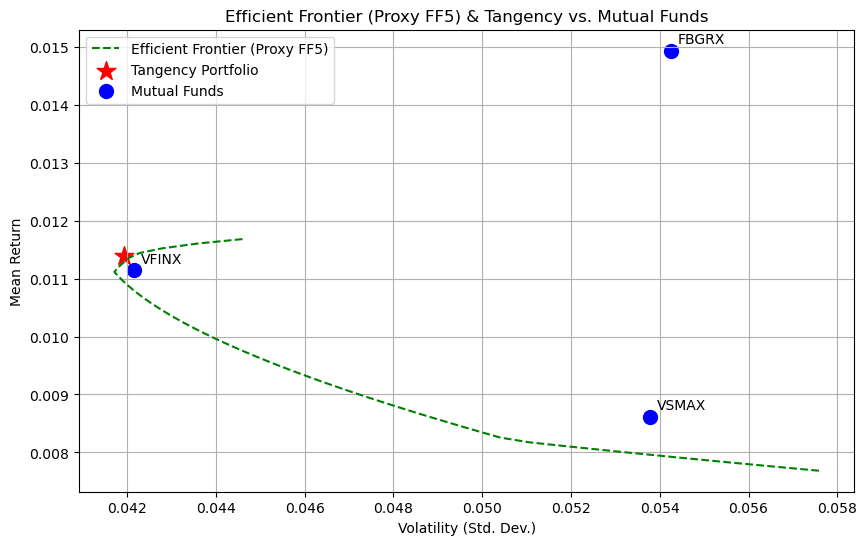

In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import datetime as dt
import matplotlib.pyplot as plt


proxy_tickers = ["SPY", "IWM", "IVE", "QUAL", "MTUM"]   # Proxy FF5 ETFs
mf_tickers    = ["VFINX", "VSMAX", "FBGRX"]            # Mutual funds
all_tickers   = proxy_tickers + mf_tickers

# Date range: from 2013-01-01 to today
start_date = '2013-01-01'
end_date   = dt.date.today()  # or a fixed date like '2024-12-31'


df_all = yf.download(all_tickers, start=start_date, end=end_date)

# Extract 'Close' prices if there's a MultiIndex
if isinstance(df_all.columns, pd.MultiIndex):
    df_close = df_all['Close']
else:
    df_close = df_all['Close']

# Option A: Strict drop of missing rows
df_close = df_close.dropna()

# 3. CONVERT DAILY PRICES TO MONTHLY RETURNS

# We resample to monthly by taking the last price each month, then compute pct_change().

df_monthly_prices = df_close.resample('ME').last()
df_monthly_returns = df_monthly_prices.pct_change().dropna()

# Separate Proxy FF5 and Mutual Funds
df_proxy = df_monthly_returns[proxy_tickers].copy()
df_mf    = df_monthly_returns[mf_tickers].copy()

# Create "print-friendly" copies (multiplied by 100)
df_proxy_for_print = df_proxy * 100
df_mf_for_print    = df_mf * 100


# 4. PRINT FIRST 5 ROWS OF PROXY DATA (MULTIPLIED BY 100)

print("First 5 rows of Proxy FF5 data after multiplying by 100:\n")
print(df_proxy_for_print.head())


def raw_sharpe_ratio(weights, returns_df):
    """
    Raw Sharpe = mean(portfolio) / std(portfolio), ignoring any risk-free rate.
    """
    mean_p = np.dot(returns_df.mean(), weights)
    std_p  = np.sqrt(weights.T @ returns_df.cov() @ weights)
    return mean_p / std_p

def neg_sharpe(weights, returns_df):
    """Negative of the raw Sharpe ratio for use in 'minimize' (which does minimization)."""
    return -raw_sharpe_ratio(weights, returns_df)

def portfolio_perf(weights, returns_df):
    """
    Returns (mean_return, volatility, raw_sharpe).
    """
    mean_p = np.dot(returns_df.mean(), weights)
    std_p  = np.sqrt(weights.T @ returns_df.cov() @ weights)
    sr_p   = mean_p / std_p
    return mean_p, std_p, sr_p


n_proxy = df_proxy.shape[1]
w0 = np.ones(n_proxy) / n_proxy
bounds = [(0, 1)] * n_proxy
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

opt_res = minimize(
    neg_sharpe,
    w0,
    args=(df_proxy,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

tang_weights = opt_res.x
tang_mean, tang_std, tang_sharpe = portfolio_perf(tang_weights, df_proxy)

print("\n=== Tangency Portfolio (Proxy FF5) ===")
print(f"\nTangency Portfolio Results:")
print(f"  Mean monthly return (%): {tang_mean*100:.2f}")
print(f"  Volatility (%): {tang_std*100:.2f}")
print(f"  Raw Sharpe: {tang_sharpe:.4f}")


print("\nFirst 5 rows of Mutual Funds data (multiplied by 100):\n")
print(df_mf_for_print.head())


# 8. MUTUAL FUNDS: MEAN, STD, RAW SHARPE

mf_means = df_mf.mean()
mf_stds  = df_mf.std()
mf_srs   = mf_means / mf_stds

print("\n=== Mutual Fund raw Sharpe Ratios (no RF subtracted) ===")
for tkr in mf_tickers:
    print(f"  {tkr}: Mean={mf_means[tkr]*100:.2f}%, Std={mf_stds[tkr]*100:.2f}%, Sharpe={mf_srs[tkr]:.4f}")

# Compare tangency portfolio Sharpe
print(f"\nTangency Portfolio (Proxy FF5) Sharpe: {tang_sharpe:.4f}")
for tkr in mf_tickers:
    print(f"{tkr} Sharpe: {mf_srs[tkr]:.4f}")


# 9. INTERPRETATION

print("\nInterpretation:")
print("- Built a tangency portfolio from the 5 Proxy FF5 ETFs (SPY, IWM, IVE, QUAL, MTUM).")
print("- If a mutual fund's Sharpe is higher, it outperforms the tangency portfolio in raw risk-return sense.")
print("- If lower, it underperforms relative to the proxy-based tangency portfolio.")
print("- Optionally, incorporate a risk-free rate or do an excess Sharpe ratio if you have matching RF data.\n")


# 10. EFFICIENT FRONTIER + PLOT

def efficient_frontier(returns_df, n_points=50):
    """
    Builds the efficient frontier by scanning target returns from the
    min to max of the assets' mean returns, then minimizing variance.
    """
    mean_returns = returns_df.mean()
    cov_matrix   = returns_df.cov()
    num_assets   = len(mean_returns)

    min_ret = mean_returns.min()
    max_ret = mean_returns.max()

    target_returns = np.linspace(min_ret, max_ret, n_points)
    frontier_vols  = []

    x0 = np.ones(num_assets) / num_assets
    
    bnds = [(0,1)] * num_assets

    for tr in target_returns:
        cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w, tr=tr: np.dot(w, mean_returns) - tr}
        ]
        resf = minimize(
            lambda w: w.T @ cov_matrix @ w,
            x0,
            method='SLSQP',
            bounds=bnds,
            constraints=cons
        )
        if resf.success:
            frontier_vols.append(np.sqrt(resf.fun))
        else:
            frontier_vols.append(np.nan)

    return frontier_vols, target_returns

frontier_vols, frontier_means = efficient_frontier(df_proxy, n_points=50)

plt.figure(figsize=(10,6))
plt.plot(frontier_vols, frontier_means, 'g--', label='Efficient Frontier (Proxy FF5)')

# Plot tangency portfolio
plt.scatter(tang_std, tang_mean, c='red', marker='*', s=200, label='Tangency Portfolio')

# Plot mutual funds
plt.scatter(mf_stds, mf_means, c='blue', s=100, label='Mutual Funds')
for tkr in mf_tickers:
    plt.annotate(
        tkr,
        (mf_stds[tkr], mf_means[tkr]),
        xytext=(5,5),
        textcoords='offset points'
    )

plt.xlabel('Volatility (Std. Dev.)')
plt.ylabel('Mean Return')
plt.title('Efficient Frontier (Proxy FF5) & Tangency vs. Mutual Funds')
plt.legend()
plt.grid(True)
plt.show()   